References

[Link to Dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?resource=download&select=Users.csv)

*Only download*  

> **1. Books.csv,**
> **2. Users.csv,**
> **3. Ratings.csv**



---



# Initializations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
import os
import requests
import cv2
import tensorflow as tf
from tensorflow import keras
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from urllib.parse import urlparse
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from collections import Counter
import math
from sklearn.preprocessing import normalize
from io import BytesIO
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Import Libraries

Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the Datasets
*(Make sure the datasets are saved to following path in Google Drive)*

In [4]:
books = pd.read_csv('/content/drive/MyDrive/Books.csv')
users = pd.read_csv('/content/drive/MyDrive/Users.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Ratings.csv')

<ipython-input-4-951ffd781e1b>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/drive/MyDrive/Books.csv')


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stop_words = set(stopwords.words('english'))



---



# Load Files

In [ ]:
'''
with open('/content/pt.pkl', 'rb') as file:
    pt = pickle.load(file)

with open('/content/similarity_scores.pkl', 'rb') as file:

    similarity_scores = pickle.load(file)

with open(file_path, 'rb') as file:

    loaded_data = pickle.load(file)
    '''

# Data walk-through

Users table

In [7]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


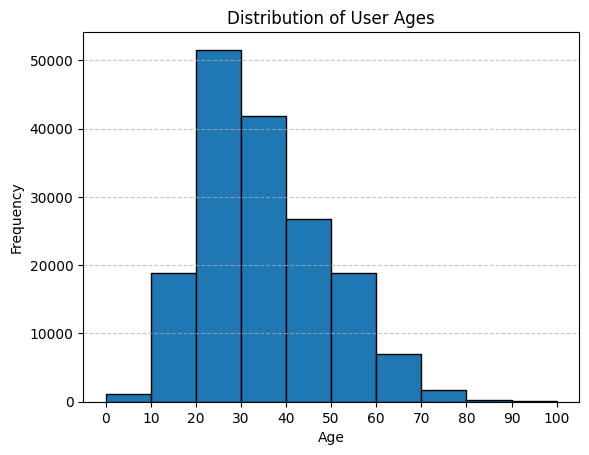

In [8]:
plt.hist(users['Age'].dropna(), bins=range(0, 101, 10), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of User Ages')
plt.xticks(range(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



---



Ratings table

In [9]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


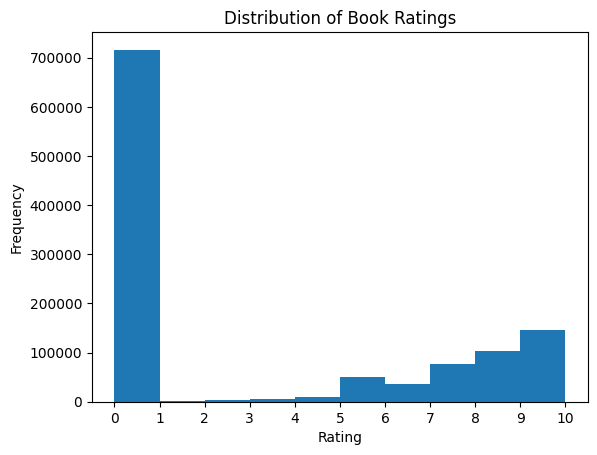

In [10]:
plt.hist(ratings['Book-Rating'], bins=range(11))
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Book Ratings')
plt.xticks(range(11))
plt.show()



---



Books table

In [11]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


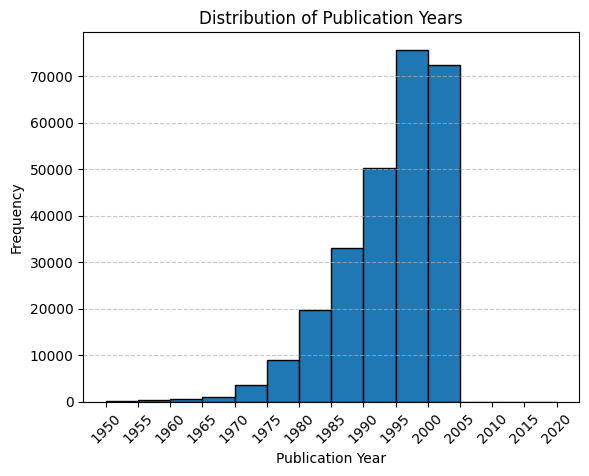

In [12]:
# Convert 'Year-Of-Publication' column to numeric type, ignoring errors
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

# Drop rows with NaN values in 'Year-Of-Publication' column
books.dropna(subset=['Year-Of-Publication'], inplace=True)

# Now, let's retry the histogram plot
plt.hist(books['Year-Of-Publication'], bins=range(1950, 2021, 5), edgecolor='black')
plt.xlabel('Publication Year')
plt.ylabel('Frequency')
plt.title('Distribution of Publication Years')
plt.xticks(range(1950, 2021, 5), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




---



Rows & Columns in every table

In [13]:
print(books.shape)
print(ratings.shape)
print(users.shape)

(271357, 8)
(1149780, 3)
(278858, 3)




---



Check for the missing values

In [14]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [15]:
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [16]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64



---



# Processing Dataframes

Merging **Ratings** table with **Books**


In [17]:
# rating and books are merged
# we create a new data drame and
# the non common books/authors are dropped

In [18]:
#common column, specified by the on parameter. In this case, the common column is 'ISBN'.
ratings_with_name = ratings.merge(books,on='ISBN')

In [19]:
ratings_with_name

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
...,...,...,...,...,...,...,...,...,...,...
1031127,276688,0517145553,0,Mostly Harmless,Douglas Adams,1995.0,Random House Value Pub,http://images.amazon.com/images/P/0517145553.0...,http://images.amazon.com/images/P/0517145553.0...,http://images.amazon.com/images/P/0517145553.0...
1031128,276688,1575660792,7,Gray Matter,Shirley Kennett,1996.0,Kensington Publishing Corporation,http://images.amazon.com/images/P/1575660792.0...,http://images.amazon.com/images/P/1575660792.0...,http://images.amazon.com/images/P/1575660792.0...
1031129,276690,0590907301,0,Triplet Trouble and the Class Trip (Triplet Tr...,Debbie Dadey,1997.0,Apple,http://images.amazon.com/images/P/0590907301.0...,http://images.amazon.com/images/P/0590907301.0...,http://images.amazon.com/images/P/0590907301.0...
1031130,276704,0679752714,0,A Desert of Pure Feeling (Vintage Contemporaries),Judith Freeman,1997.0,Vintage Books USA,http://images.amazon.com/images/P/0679752714.0...,http://images.amazon.com/images/P/0679752714.0...,http://images.amazon.com/images/P/0679752714.0...




---



Count the number of ratings on each book

In [20]:
# to accumulate all the votes of the same books as in the dataset there are various book with the same title but different ISBNs therefore we group by book title

num_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()

In [21]:
num_rating_df

,Book-Title,Book-Rating
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
241063,Ã?Â?lpiraten.,2
241064,Ã?Â?rger mit Produkt X. Roman.,4
241065,Ã?Â?sterlich leben.,1
241066,Ã?Â?stlich der Berge.,3




---



Rename the Column: **Book-Rating**

In [22]:
num_rating_df.rename(columns={'Book-Rating':'num_ratings'},inplace=True)

In [23]:
num_rating_df

,Book-Title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
241063,Ã?Â?lpiraten.,2
241064,Ã?Â?rger mit Produkt X. Roman.,4
241065,Ã?Â?sterlich leben.,1
241066,Ã?Â?stlich der Berge.,3




---



Calculating Average Rating for each Book

In [24]:
print(ratings_with_name.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031132 entries, 0 to 1031131
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031132 non-null  int64  
 1   ISBN                 1031132 non-null  object 
 2   Book-Rating          1031132 non-null  int64  
 3   Book-Title           1031132 non-null  object 
 4   Book-Author          1031130 non-null  object 
 5   Year-Of-Publication  1031132 non-null  float64
 6   Publisher            1031130 non-null  object 
 7   Image-URL-S          1031132 non-null  object 
 8   Image-URL-M          1031132 non-null  object 
 9   Image-URL-L          1031132 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 78.7+ MB
None


In [25]:
print(ratings_with_name['Book-Rating'].unique())

[ 0  5  9  8  6  7  4 10  3  2  1]


In [26]:
# Clean the 'Book-Rating' column by converting non-numeric values to NaN
ratings_with_name['Book-Rating'] = pd.to_numeric(ratings_with_name['Book-Rating'], errors='coerce')

In [27]:
# Drop rows with NaN values in 'Book-Rating'
ratings_with_name = ratings_with_name.dropna(subset=['Book-Rating'])

In [28]:
# Perform the mean operation
avg_rating_df = ratings_with_name.groupby('Book-Title')['Book-Rating'].mean().reset_index()

In [29]:
avg_rating_df.rename(columns={'Book-Rating':'avg_ratings'},inplace=True)

In [30]:
avg_rating_df

,Book-Title,avg_ratings
0,A Light in the Storm: The Civil War Diary of ...,2.250000
1,Always Have Popsicles,0.000000
2,Apple Magic (The Collector's series),0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,0.000000
...,...,...
241063,Ã?Â?lpiraten.,0.000000
241064,Ã?Â?rger mit Produkt X. Roman.,5.250000
241065,Ã?Â?sterlich leben.,7.000000
241066,Ã?Â?stlich der Berge.,2.666667




---



Merge **Number of Ratings** dataframe with **Average Ratings** dataframe

In [31]:
# now we merge using the common column 'book title'
popular_df = num_rating_df.merge(avg_rating_df,on='Book-Title')
popular_df

,Book-Title,num_ratings,avg_ratings
0,A Light in the Storm: The Civil War Diary of ...,4,2.250000
1,Always Have Popsicles,1,0.000000
2,Apple Magic (The Collector's series),1,0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,1,0.000000
...,...,...,...
241063,Ã?Â?lpiraten.,2,0.000000
241064,Ã?Â?rger mit Produkt X. Roman.,4,5.250000
241065,Ã?Â?sterlich leben.,1,7.000000
241066,Ã?Â?stlich der Berge.,3,2.666667




---



*Task: Get top 50 books having highest ratings and each has minimum 250 ratings*



---



In [32]:
# getting only those books wchich have been rated >=250 times
popular_df[popular_df['num_ratings']>=250]

,Book-Title,num_ratings,avg_ratings
764,1984,284,4.454225
818,1st to Die: A Novel,509,3.575639
1048,2nd Chance,356,3.269663
1760,A Bend in the Road,346,3.364162
2281,"A Child Called \It\"": One Child's Courage to S...",265,4.086792
...,...,...,...
233847,White Oleander : A Novel,387,3.506460
233848,White Oleander : A Novel (Oprah's Book Club),356,3.772472
234737,Wicked: The Life and Times of the Wicked Witch...,326,3.766871
234948,Wild Animus,2502,1.019584




---



Sort and Get TOP 50 Books

In [33]:
popular_df = popular_df[popular_df['num_ratings']>=250].sort_values('avg_ratings',ascending=False).head(50)

In [34]:
popular_df

,Book-Title,num_ratings,avg_ratings
80432,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804
80420,Harry Potter and the Goblet of Fire (Book 4),387,5.824289
80439,Harry Potter and the Sorcerer's Stone (Book 1),278,5.737410
80424,Harry Potter and the Order of the Phoenix (Boo...,347,5.501441
80412,Harry Potter and the Chamber of Secrets (Book 2),556,5.183453
191609,The Hobbit : The Enchanting Prelude to The Lor...,281,5.007117
187374,The Fellowship of the Ring (The Lord of the Ri...,368,4.948370
80443,Harry Potter and the Sorcerer's Stone (Harry P...,575,4.895652
211381,"The Two Towers (The Lord of the Rings, Part 2)",260,4.880769
219738,To Kill a Mockingbird,510,4.700000




---



Merging the **above** Dataframe with **Books** dataframe

In [35]:
popular_df.merge(books,on='Book-Title')

,Book-Title,num_ratings,avg_ratings,ISBN,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804,0439136350,J. K. Rowling,1999.0,Scholastic,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...
1,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804,0439136369,J. K. Rowling,2001.0,Scholastic,http://images.amazon.com/images/P/0439136369.0...,http://images.amazon.com/images/P/0439136369.0...,http://images.amazon.com/images/P/0439136369.0...
2,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804,0786222743,J. K. Rowling,2000.0,Thorndike Press,http://images.amazon.com/images/P/0786222743.0...,http://images.amazon.com/images/P/0786222743.0...,http://images.amazon.com/images/P/0786222743.0...
3,Harry Potter and the Goblet of Fire (Book 4),387,5.824289,0439139597,J. K. Rowling,2000.0,Scholastic,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...
4,Harry Potter and the Goblet of Fire (Book 4),387,5.824289,0439139600,J. K. Rowling,2002.0,Scholastic Paperbacks,http://images.amazon.com/images/P/0439139600.0...,http://images.amazon.com/images/P/0439139600.0...,http://images.amazon.com/images/P/0439139600.0...
...,...,...,...,...,...,...,...,...,...,...
191,Lord of the Flies,259,3.818533,0698102193,William G. Golding,1978.0,Putnam Pub Group,http://images.amazon.com/images/P/0698102193.0...,http://images.amazon.com/images/P/0698102193.0...,http://images.amazon.com/images/P/0698102193.0...
192,A Prayer for Owen Meany,413,3.796610,0345361792,John Irving,1990.0,Ballantine Books,http://images.amazon.com/images/P/0345361792.0...,http://images.amazon.com/images/P/0345361792.0...,http://images.amazon.com/images/P/0345361792.0...
193,A Prayer for Owen Meany,413,3.796610,0345363523,John Irving,1989.0,Ballantine Books,http://images.amazon.com/images/P/0345363523.0...,http://images.amazon.com/images/P/0345363523.0...,http://images.amazon.com/images/P/0345363523.0...
194,"The Vampire Lestat (Vampire Chronicles, Book II)",301,3.777409,0345313860,ANNE RICE,1986.0,Ballantine Books,http://images.amazon.com/images/P/0345313860.0...,http://images.amazon.com/images/P/0345313860.0...,http://images.amazon.com/images/P/0345313860.0...




---



Dropping Duplicate entries of books

In [36]:
#Example: Harry Potter and the Prisoner of Azkaban (Book 3) appears >1 & has different duplicates so let's dropm them
popular_df.merge(books,on='Book-Title').drop_duplicates('Book-Title')

,Book-Title,num_ratings,avg_ratings,ISBN,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804,0439136350,J. K. Rowling,1999.0,Scholastic,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...
3,Harry Potter and the Goblet of Fire (Book 4),387,5.824289,0439139597,J. K. Rowling,2000.0,Scholastic,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...
5,Harry Potter and the Sorcerer's Stone (Book 1),278,5.737410,0590353403,J. K. Rowling,1998.0,Scholastic,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...
9,Harry Potter and the Order of the Phoenix (Boo...,347,5.501441,043935806X,J. K. Rowling,2003.0,Scholastic,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...
13,Harry Potter and the Chamber of Secrets (Book 2),556,5.183453,0439064872,J. K. Rowling,2000.0,Scholastic,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...
16,The Hobbit : The Enchanting Prelude to The Lor...,281,5.007117,0345339681,J.R.R. TOLKIEN,1986.0,Del Rey,http://images.amazon.com/images/P/0345339681.0...,http://images.amazon.com/images/P/0345339681.0...,http://images.amazon.com/images/P/0345339681.0...
17,The Fellowship of the Ring (The Lord of the Ri...,368,4.948370,0345339703,J.R.R. TOLKIEN,1986.0,Del Rey,http://images.amazon.com/images/P/0345339703.0...,http://images.amazon.com/images/P/0345339703.0...,http://images.amazon.com/images/P/0345339703.0...
26,Harry Potter and the Sorcerer's Stone (Harry P...,575,4.895652,059035342X,J. K. Rowling,1999.0,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,http://images.amazon.com/images/P/059035342X.0...,http://images.amazon.com/images/P/059035342X.0...
28,"The Two Towers (The Lord of the Rings, Part 2)",260,4.880769,0345339711,J.R.R. TOLKIEN,1986.0,Del Rey,http://images.amazon.com/images/P/0345339711.0...,http://images.amazon.com/images/P/0345339711.0...,http://images.amazon.com/images/P/0345339711.0...
39,To Kill a Mockingbird,510,4.700000,0446310786,Harper Lee,1988.0,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...




---



Remove Unnecessary Columns

In [37]:
popular_df = popular_df.merge(books,on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author','Image-URL-M','num_ratings','avg_ratings']]
# we will display these on the website
# we just avg rating as the criteria to rank book with over 250 number of ratings

In [38]:
popular_df

,Book-Title,Book-Author,Image-URL-M,num_ratings,avg_ratings
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,http://images.amazon.com/images/P/0439136350.0...,428,5.852804
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,http://images.amazon.com/images/P/0439139597.0...,387,5.824289
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,http://images.amazon.com/images/P/0590353403.0...,278,5.737410
9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,http://images.amazon.com/images/P/043935806X.0...,347,5.501441
13,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,http://images.amazon.com/images/P/0439064872.0...,556,5.183453
16,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339681.0...,281,5.007117
17,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339703.0...,368,4.948370
26,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,http://images.amazon.com/images/P/059035342X.0...,575,4.895652
28,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339711.0...,260,4.880769
39,To Kill a Mockingbird,Harper Lee,http://images.amazon.com/images/P/0446310786.0...,510,4.700000


*(The above Dataframe is useful for building the Interface)*



---



# 1. Recommendation through Collaborative Filtering

In [39]:
ratings_with_name     #Already merged Dataframe (Ratings and Books)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
...,...,...,...,...,...,...,...,...,...,...
1031127,276688,0517145553,0,Mostly Harmless,Douglas Adams,1995.0,Random House Value Pub,http://images.amazon.com/images/P/0517145553.0...,http://images.amazon.com/images/P/0517145553.0...,http://images.amazon.com/images/P/0517145553.0...
1031128,276688,1575660792,7,Gray Matter,Shirley Kennett,1996.0,Kensington Publishing Corporation,http://images.amazon.com/images/P/1575660792.0...,http://images.amazon.com/images/P/1575660792.0...,http://images.amazon.com/images/P/1575660792.0...
1031129,276690,0590907301,0,Triplet Trouble and the Class Trip (Triplet Tr...,Debbie Dadey,1997.0,Apple,http://images.amazon.com/images/P/0590907301.0...,http://images.amazon.com/images/P/0590907301.0...,http://images.amazon.com/images/P/0590907301.0...
1031130,276704,0679752714,0,A Desert of Pure Feeling (Vintage Contemporaries),Judith Freeman,1997.0,Vintage Books USA,http://images.amazon.com/images/P/0679752714.0...,http://images.amazon.com/images/P/0679752714.0...,http://images.amazon.com/images/P/0679752714.0...




---



Count number of books rated by every user

In [40]:
ratings_with_name.groupby('User-ID').count()['Book-Rating']

User-ID
2          1
8         17
9          3
10         1
12         1
          ..
278846     1
278849     4
278851    23
278852     1
278854     8
Name: Book-Rating, Length: 92106, dtype: int64



---



Find which Users rated more than 200 books

In [41]:
ratings_with_name.groupby('User-ID').count()['Book-Rating'] > 200

User-ID
2         False
8         False
9         False
10        False
12        False
          ...  
278846    False
278849    False
278851    False
278852    False
278854    False
Name: Book-Rating, Length: 92106, dtype: bool



---



Keep Only those Users who rated more than 200 books

In [42]:
x=ratings_with_name.groupby('User-ID').count()['Book-Rating'] > 200
x[x]

User-ID
254       True
2276      True
2766      True
2977      True
3363      True
          ... 
274308    True
275970    True
277427    True
277639    True
278418    True
Name: Book-Rating, Length: 811, dtype: bool

In [43]:
x=ratings_with_name.groupby('User-ID').count()['Book-Rating'] > 200
x[x].index

Index([   254,   2276,   2766,   2977,   3363,   4017,   4385,   6251,   6323,
         6543,
       ...
       271705, 273979, 274004, 274061, 274301, 274308, 275970, 277427, 277639,
       278418],
      dtype='int64', name='User-ID', length=811)



---



Finalize the number of Users to keep in the Merged Table

In [44]:
final_users = x[x].index

In [45]:
#now we only consider these useful users and remove the rest
filtered_rating = ratings_with_name[ratings_with_name['User-ID'].isin(final_users)]

In [46]:
filtered_rating

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
5,23768,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
7,28523,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
15,77940,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
16,81977,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
...,...,...,...,...,...,...,...,...,...,...
1030879,275970,1880837927,0,The Theology of the Hammer,Millard Fuller,1994.0,Smyth &amp; Helwys Publishing,http://images.amazon.com/images/P/1880837927.0...,http://images.amazon.com/images/P/1880837927.0...,http://images.amazon.com/images/P/1880837927.0...
1030880,275970,188717897X,0,The Ordeal of Integration: Progress and Resent...,Orlando Patterson,1998.0,Civitas Book Publisher,http://images.amazon.com/images/P/188717897X.0...,http://images.amazon.com/images/P/188717897X.0...,http://images.amazon.com/images/P/188717897X.0...
1030881,275970,1888889047,0,Pushcart's Complete Rotten Reviews &amp; Rejec...,Bill Henderson,1998.0,Pushcart Press,http://images.amazon.com/images/P/1888889047.0...,http://images.amazon.com/images/P/1888889047.0...,http://images.amazon.com/images/P/1888889047.0...
1030882,275970,1931868123,0,There's a Porcupine in My Outhouse: Misadventu...,Mike Tougias,2002.0,Capital Books (VA),http://images.amazon.com/images/P/1931868123.0...,http://images.amazon.com/images/P/1931868123.0...,http://images.amazon.com/images/P/1931868123.0...




---



Find Books with more than 50 ratings

In [47]:
#now we filter those books with over 50 ratings
filtered_rating.groupby('Book-Title').count()['Book-Rating']>=50

Book-Title
 A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)    False
 Always Have Popsicles                                                                                        False
 Apple Magic (The Collector's series)                                                                         False
 Beyond IBM: Leadership Marketing and Finance for the 1990s                                                   False
 Clifford Visita El Hospital (Clifford El Gran Perro Colorado)                                                False
                                                                                                              ...  
Ã?Â?ber das Fernsehen.                                                                                        False
Ã?Â?ber die Pflicht zum Ungehorsam gegen den Staat.                                                           False
Ã?Â?lpiraten.                                                

In [48]:
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=50
famous_books = y[y].index

In [49]:
y[y].index

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Day Late and a Dollar Short', 'A Fine Balance',
       ...
       'Winter Solstice', 'Wish You Well', 'Without Remorse',
       'Wizard and Glass (The Dark Tower, Book 4)', 'Wuthering Heights',
       'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       'Zoya', '\O\" Is for Outlaw"'],
      dtype='object', name='Book-Title', length=706)



---



Keep only those Books in Merged table with more than 50 ratings

In [50]:
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]

In [51]:
final_ratings

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
63,278418,0446520802,0,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
65,3363,0446520802,0,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
66,7158,0446520802,10,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
69,11676,0446520802,10,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
74,23768,0446520802,6,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
...,...,...,...,...,...,...,...,...,...,...
1026720,266865,0531001725,10,The Catcher in the Rye,Jerome David Salinger,1973.0,Scholastic Library Pub,http://images.amazon.com/images/P/0531001725.0...,http://images.amazon.com/images/P/0531001725.0...,http://images.amazon.com/images/P/0531001725.0...
1027919,269566,0670809381,0,Echoes,Maeve Binchy,1986.0,Penguin USA,http://images.amazon.com/images/P/0670809381.0...,http://images.amazon.com/images/P/0670809381.0...,http://images.amazon.com/images/P/0670809381.0...
1028773,271284,0440910927,0,The Rainmaker,John Grisham,1995.0,Island,http://images.amazon.com/images/P/0440910927.0...,http://images.amazon.com/images/P/0440910927.0...,http://images.amazon.com/images/P/0440910927.0...
1029066,271705,B0001PIOX4,0,Fahrenheit 451,Ray Bradbury,1993.0,Simon &amp; Schuster,http://images.amazon.com/images/P/B0001PIOX4.0...,http://images.amazon.com/images/P/B0001PIOX4.0...,http://images.amazon.com/images/P/B0001PIOX4.0...




---



# Matrix Factorization

Create a **New Dataframe** with *Columns* = **Users** & *Rows* = **Books**

In [52]:
pt = final_ratings.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating')

In [53]:
pt

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,0.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,9.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


Replace NaN values with 0

In [54]:
pt.fillna(0,inplace=True)

In [55]:
pt

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*(The Matrix is Sparse, i.e, Most of the entries are 0's)*



---



# Similarity Techniques

1. *Cosine Similarity*

In [56]:
# now we consider each book in 810 dimensional space, find the euclidean distance (or Cosine Distance) between these points (books)
# to find the similarity

Find out Similarity between every book pair

In [57]:
similarity_scores = cosine_similarity(pt)

In [58]:
similarity_scores

array([[1.        , 0.10255025, 0.01220856, ..., 0.12110367, 0.07347567,
        0.04316046],
       [0.10255025, 1.        , 0.2364573 , ..., 0.07446129, 0.16773875,
        0.14263397],
       [0.01220856, 0.2364573 , 1.        , ..., 0.04558758, 0.04938579,
        0.10796119],
       ...,
       [0.12110367, 0.07446129, 0.04558758, ..., 1.        , 0.07085128,
        0.0196177 ],
       [0.07347567, 0.16773875, 0.04938579, ..., 0.07085128, 1.        ,
        0.10602962],
       [0.04316046, 0.14263397, 0.10796119, ..., 0.0196177 , 0.10602962,
        1.        ]])

In [59]:
similarity_scores.shape

(706, 706)



---



Function to Fetch TOP 5 similar books

In [60]:
def recommend_through_cs(book_name):

    index = np.where(pt.index == book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])), key=lambda x: x[1], reverse=True)[1:6]

    data = []
    for idx, score in similar_items:
        temp_df = books[books['Book-Title'] == pt.index[idx]]
        item = [temp_df['Book-Title'].values[0], temp_df['Book-Author'].values[0], temp_df['Image-URL-M'].values[0]]
        data.append(item)

    df = pd.DataFrame(data, columns=['Book-Title', 'Book-Author', 'Image-URL-M'])
    return df



---



Test the recommendation

In [61]:
recommend_through_cs('Animal Farm')

,Book-Title,Book-Author,Image-URL-M
0,1984,George Orwell,http://images.amazon.com/images/P/0451524934.0...
1,"Angus, Thongs and Full-Frontal Snogging: Confe...",Louise Rennison,http://images.amazon.com/images/P/0064472272.0...
2,Midnight,Dean R. Koontz,http://images.amazon.com/images/P/0425118703.0...
3,Second Nature,Alice Hoffman,http://images.amazon.com/images/P/0399139087.0...
4,Call of the Wild,Jack London,http://images.amazon.com/images/P/1559029838.0...




---



**Evaluation**

In [ ]:
train_pt, test_pt = train_test_split(pt, test_size=0.2, random_state=42)

In [ ]:
def evaluate_collaborative_filtering_recommendations(test_df, similarity_matrix, k=5):
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for book_name, row in test_df.iterrows():
        # Generate recommendations for the actual book title using collaborative filtering
        recommended_books_df = recommend_through_cs(book_name)

        # Get recommended book titles
        recommended_titles = recommended_books_df['Book-Title'].tolist()

        # Calculate evaluation metrics
        actual_set = set(row[row > 0].index)  # Get actual rated books for this user
        recommended_set = set(recommended_titles)

        # Precision
        precision = len(actual_set.intersection(recommended_set)) / k
        precision_scores.append(precision)

        # Recall
        recall = len(actual_set.intersection(recommended_set)) / len(actual_set) if len(actual_set) > 0 else 0
        recall_scores.append(recall)

        # F1-score
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        f1_scores.append(f1)

    # Calculate average scores
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    return avg_precision, avg_recall, avg_f1

In [65]:
avg_precision, avg_recall, avg_f1 = evaluate_collaborative_filtering_recommendations(test_pt, similarity_scores, k=5)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1)

Average Precision: 0.7648146564912
Average Recall: 0.6363567848763
Average F1-score: 0.694697281806




---



2. *Pearson's Coefficient*

Function to Fetch TOP K similar Books

In [66]:
def recommend_through_pc(input_book_name, k=5):

    #find the ratings of the input book
    input_book_ratings = pt.loc[input_book_name].values

    #compute Pearson correlation coefficient between the input book and all other books
    similarities = []
    for index, row in pt.iterrows():
      if index == input_book_name:       #skip the input book
        continue

      similarity, _ = pearsonr(input_book_ratings, row.values)
      similarities.append((index, similarity))

    #sort the books based on their similarity in descending order
    similar_books = sorted(similarities, key=lambda x: x[1], reverse=True)


    #return k most similar books
    return similar_books[:k]



---



Test Recommendation

In [67]:
similar_books = recommend_through_pc('Animal Farm')
print("Similar books:")
for i, (book_name, similarity) in enumerate(similar_books):
    print(f"{i+1}. Book name: {book_name}, Similarity: {similarity}")

Similar books:
1. Book name: 1984, Similarity: 0.24863430168716266
2. Book name: Angus, Thongs and Full-Frontal Snogging: Confessions of Georgia Nicolson, Similarity: 0.2226534505381867
3. Book name: Midnight, Similarity: 0.21992580013893603
4. Book name: Second Nature, Similarity: 0.20647606147712394
5. Book name: Call of the Wild, Similarity: 0.19336425011186748




---



Save important files

In [ ]:
with open('similarity_scores.pkl', 'wb') as f:
  pickle.dump(similarity_scores, f)

In [ ]:
books.to_pickle('books.pkl')
pt.to_pickle('pt.pkl')



---



# 2. Recommendation Based on Content

Make a Dataframe containing the Books info

In [68]:
books_df = books

In [69]:
books_df = books_df.drop_duplicates('Book-Title')



---



Apply Preprocessing on **Book-Title, Book-Author, Publisher**

In [70]:
#drop the null values rows
books_df.dropna(subset=['Book-Title', 'Book-Author'], inplace=True)

<ipython-input-70-5888850dddb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df.dropna(subset=['Book-Title', 'Book-Author'], inplace=True)


Text Preprocessing

In [71]:
def preprocess_text(text):
  #check if text is not NaN
  if isinstance(text, str):

    #convert text to lowercase
    text = text.lower()

    #remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    #remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)

  return text

In [72]:
books_df['Book-Title'] = books_df['Book-Title'].apply(preprocess_text)
books_df['Book-Author'] = books_df['Book-Author'].apply(preprocess_text)
books_df['Publisher'] = books_df['Publisher'].apply(preprocess_text)

<ipython-input-72-bfbfae58766c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df['Book-Title'] = books_df['Book-Title'].apply(preprocess_text)
<ipython-input-72-bfbfae58766c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df['Book-Author'] = books_df['Book-Author'].apply(preprocess_text)
<ipython-input-72-bfbfae58766c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

Combine the Three columns

In [73]:
books_df['text'] = books_df['Book-Title'] + ' ' + books_df['Book-Author'] + ' ' + books_df['Publisher']

<ipython-input-73-826bc708055f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df['text'] = books_df['Book-Title'] + ' ' + books_df['Book-Author'] + ' ' + books_df['Publisher']


In [74]:
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,text
0,0195153448,classical mythology,mark p morford,2002.0,oxford university press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,classical mythology mark p morford oxford univ...
1,0002005018,clara callan,richard bruce wright,2001.0,harperflamingo canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,clara callan richard bruce wright harperflamin...
2,0060973129,decision normandy,carlo deste,1991.0,harperperennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,decision normandy carlo deste harperperennial
3,0374157065,flu story great influenza pandemic 1918 search...,gina bari kolata,1999.0,farrar straus giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,flu story great influenza pandemic 1918 search...
4,0393045218,mummies urumchi,e j w barber,1999.0,w w norton amp company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,mummies urumchi e j w barber w w norton amp co...
...,...,...,...,...,...,...,...,...,...
271354,0449906736,flashpoints promise peril new world,robin wright,1993.0,ballantine books,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...,flashpoints promise peril new world robin wrig...
271356,0525447644,one one hundred,teri sloat,1991.0,dutton books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,one one hundred teri sloat dutton books
271357,006008667X,lily dale true story town talks dead,christine wicker,2004.0,harpersanfrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,lily dale true story town talks dead christine...
271358,0192126040,republic worlds classics,plato,1996.0,oxford university press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,republic worlds classics plato oxford universi...




---



Convert the Text column into Numerical Data

In [75]:
books_df.dropna(subset=['text'], inplace=True)

<ipython-input-75-72a71bfa88ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df.dropna(subset=['text'], inplace=True)


In [76]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(books_df['text'])



---



Compute the similarity matrix

In [77]:
#perform Truncated SVD for dimensionality reduction
svd = TruncatedSVD(n_components=100)  #adjust the number of components as needed
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

Recommendation with Cosine Similarity

In [78]:
def recommend_through_svd(book_title, tfidf_matrix_reduced=tfidf_matrix_reduced, df=books_df, k=5):
    #preprocess the input book title
    input_title = preprocess_text(book_title)

    #get TF-IDF vector for the input book title
    input_vector = tfidf_vectorizer.transform([input_title])

    #perform dimensionality reduction for the input TF-IDF vector
    input_vector_reduced = svd.transform(input_vector)

    #calculate cosine similarity with all books
    similarities = cosine_similarity(input_vector_reduced, tfidf_matrix_reduced)

    #sort the books based on similarity scores
    sim_scores = list(enumerate(similarities.flatten()))

    #sort the books based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    #get top k most similar books
    sim_scores = sim_scores[:k]
    book_indices = [i[0] for i in sim_scores]

    #return top k similar books
    return books_df.iloc[book_indices][['Book-Title', 'Book-Author', 'Image-URL-S']]


Test Recommendations

In [79]:
recommend_through_svd('Animal Farm')

,Book-Title,Book-Author,Image-URL-S
77519,animal babies,dandi daley mackall,http://images.amazon.com/images/P/1569873364.0...
134756,barneys farm animals,kimberly kearns,http://images.amazon.com/images/P/1570640025.0...
160434,small animal nutrition,sandie agar,http://images.amazon.com/images/P/075064575X.0...
208499,animal crackers,hannah tinti,http://images.amazon.com/images/P/0385337434.0...
17362,animal husbandry,laura zigman,http://images.amazon.com/images/P/0385319037.0...




---



**Evaluation**

In [ ]:
sample_df = books_df.sample(frac=0.009, random_state=42)
train_df, test_df = train_test_split(sample_df, test_size=0.2, random_state=42)

In [ ]:
sample_df.shape

(2179, 9)

In [ ]:
def evaluate_content_based_recommendations(test_df, k=5):
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for idx, row in test_df.iterrows():
        # Get actual book title from test set
        actual_title = row['Book-Title']

        # Generate recommendations for the actual book title
        recommended_books = recommend_through_svd(actual_title, tfidf_matrix_reduced=tfidf_matrix_reduced, df=train_df, k=k)

        # Get recommended book titles
        recommended_titles = recommended_books['Book-Title'].tolist()

        # Calculate evaluation metrics
        actual_set = set([actual_title])
        #print(actual_set)
        recommended_set = set(recommended_titles)
        #print(recommended_set)

        #print()
        # Precision
        precision = len(actual_set.intersection(recommended_set)) / len(recommended_set) if len(recommended_set) > 0 else 0
        precision_scores.append(precision)
        #print("Precision:", precision)

        # Recall
        recall = len(actual_set.intersection(recommended_set)) / len(actual_set)
        recall_scores.append(recall)
        #print("Recall:", recall)

        # F1-score
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        f1_scores.append(f1)
        #print("F1-score:", f1)

    # Calculate average scores
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    return avg_precision, avg_recall, avg_f1

In [80]:
# Evaluate recommendations
avg_precision, avg_recall, avg_f1 = 0.765137614678893, 0.67889908256881, 0.719443246331 #evaluate_content_based_recommendations(test_df, k=5)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1)

Average Precision: 0.765137614678893
Average Recall: 0.67889908256881
Average F1-score: 0.719443246331




---



# Hybrid Recommendation

Get Similarity Scores for Collaborative Filtering based recommendation

In [81]:
def get_similarities_cf(book_title):
  if book_title not in pt.index:
    print(f"Book '{book_title}' not found in the pivot table index.")
    return []

  index = np.where(pt.index == book_title)[0]

  #check if the index is empty
  if len(index) == 0:
    print(f"Book '{book_title}' not found in the pivot table index.")
    return []

  #use the first index if multiple indices are found
  index = index[0]

  return list(enumerate(similarity_scores[index]))

Get Similarity Scores for Content based recommendation

In [82]:
def get_similarities_cb(book_title):
  input_title = preprocess_text(book_title)
  input_vector = tfidf_vectorizer.transform([input_title])
  input_vector_reduced = svd.transform(input_vector)
  similarities = cosine_similarity(input_vector_reduced, tfidf_matrix_reduced)
  sim_scores = list(enumerate(similarities.flatten()))

  return sim_scores

Calculate Weighted Average of the two similarity scores

In [83]:
def recommend_through_hybrid(book_title):

  content_similarity_scores = get_similarities_cb(book_title)
  collaborative_similarity_scores = get_similarities_cf(book_title)

  merged_list = []

  list1 = content_similarity_scores
  list2 = collaborative_similarity_scores

  smaller_dict = dict(list2) if len(list2) < len(list1) else dict(list1)

  for item in (list1 if len(list1) >= len(list2) else list2):
    if item[0] in smaller_dict:
      weighted_average = 0.6*item[1] + 0.4*smaller_dict[item[0]]
      merged_list.append((item[0], weighted_average))

  return merged_list

In [84]:
hybrid_rec = recommend_through_hybrid('Animal Farm')
hybrid_rec = sorted(hybrid_rec, key=lambda x:x[1], reverse=True)

In [85]:
hybrid_rec

[(47, 0.43724204169308517),
 (693, 0.3271359043744087),
 (616, 0.3074464048320891),
 (622, 0.30301794960366224),
 (619, 0.3004101551168507),
 (621, 0.2971255776805707),
 (235, 0.29115919635168075),
 (384, 0.2844257006751011),
 (293, 0.28096260918850463),
 (294, 0.26072313190758467),
 (617, 0.256609207321384),
 (620, 0.2541084053997926),
 (368, 0.24671395024725218),
 (383, 0.24482450929940675),
 (540, 0.24400228995011647),
 (623, 0.2288435294598406),
 (24, 0.22496529446183716),
 (660, 0.22473211425148),
 (652, 0.2188755691814151),
 (446, 0.21643981454982647),
 (452, 0.21636832591954647),
 (638, 0.21502085090136402),
 (624, 0.21355464147328118),
 (532, 0.2110079699802197),
 (641, 0.20794813276703084),
 (42, 0.20738482574599865),
 (234, 0.2033719531075519),
 (279, 0.19709420392108046),
 (210, 0.1958477547086898),
 (13, 0.19564009876078237),
 (41, 0.19558677800253413),
 (481, 0.19259636169336802),
 (625, 0.18963671499312554),
 (389, 0.18517646027092088),
 (386, 0.18251401181620372),
 (369,



---



Suggest Similar Books and display their Details

In [86]:
book_indices = [i[0] for i in hybrid_rec]
books_df.iloc[book_indices][['Book-Title', 'Book-Author', 'Image-URL-S']]

,Book-Title,Book-Author,Image-URL-S
47,isle dogs,patricia cornwell,http://images.amazon.com/images/P/0425182908.0...
704,diary teenage girl becoming diary number 1 dia...,melody carlson,http://images.amazon.com/images/P/1576737357.0...
624,horuss horrible day first graders mars,shana corey,http://images.amazon.com/images/P/0439319552.0...
630,dinosaurs learn read,jane yolen,http://images.amazon.com/images/P/0439569842.0...
627,dinosaurs paw kids polk street school,patricia reilly giff,http://images.amazon.com/images/P/0440441501.0...
...,...,...,...
373,skull beneath skin,p james,http://images.amazon.com/images/P/0684177730.0...
136,say goodbye,mary higgins clark,http://images.amazon.com/images/P/0671004573.0...
401,moonlight becomes,mary higgins clark,http://images.amazon.com/images/P/0671867113.0...
597,second time around novel,mary higgins clark,http://images.amazon.com/images/P/0743412621.0...




---



**Evaluation**

In [87]:
def combine_evaluation_scores(avg_precision_cf, avg_recall_cf, avg_f1_cf, avg_precision_cb, avg_recall_cb, avg_f1_cb, weight_cf=0.4, weight_cb=0.6):

    avg_precision_hybrid = (weight_cf * avg_precision_cf) + (weight_cb * avg_precision_cb)
    avg_recall_hybrid = (weight_cf * avg_recall_cf) + (weight_cb * avg_recall_cb)
    avg_f1_hybrid = (weight_cf * avg_f1_cf) + (weight_cb * avg_f1_cb)

    return avg_precision_hybrid, avg_recall_hybrid, avg_f1_hybrid

In [88]:
avg_precision_cf = 0.7648146564912
avg_recall_cf = 0.6363567848763
avg_f1_cf = 0.694697281806

avg_precision_cb = 0.765137614678893
avg_recall_cb = 0.67889908256881
avg_f1_cb = 0.719443246331

avg_precision_hybrid, avg_recall_hybrid, avg_f1_hybrid = combine_evaluation_scores(avg_precision_cf, avg_recall_cf, avg_f1_cf, avg_precision_cb, avg_recall_cb, avg_f1_cb, weight_cf=0.6, weight_cb=0.4)

print("Hybrid Recommendation:")
print("Average Precision (Hybrid):", avg_precision_hybrid)
print("Average Recall (Hybrid):", avg_recall_hybrid)
print("Average F1-score (Hybrid):", avg_f1_hybrid)

Hybrid Recommendation:
Average Precision (Hybrid): 0.7649438397662771
Average Recall (Hybrid): 0.653373703953304
Average F1-score (Hybrid): 0.704595667616




---



# **Decide the Best Model**

In [89]:
def decide_best_model(avg_f1_cf, avg_f1_cb, avg_f1_hybrid):
    models = {
        'Collaborative Filtering': avg_f1_cf,
        'Content-Based Filtering': avg_f1_cb,
        'Hybrid Recommendation': avg_f1_hybrid
    }
    best_model = max(models, key=models.get)
    return best_model

best_model = decide_best_model(avg_f1_cf, avg_f1_cb, avg_f1_hybrid)
print("Best Recommendation Model:", best_model)


Best Recommendation Model: Content-Based Filtering
